In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import sqlite3

In [5]:
def_storage_phish = "db/new_region_data_phishing_labeled_filtered.db"
def_storage_benign = "db/new_region_data_benign_labeled_filtered.db"

# get phishing region data in dataframe
conn = sqlite3.connect(def_storage_phish)
df_phish = pd.read_sql_query("SELECT * from region_info", conn)
conn.close()

# get benign region data in dataframe
conn = sqlite3.connect(def_storage_benign)
df_benign = pd.read_sql_query("SELECT * from region_info", conn)
conn.close()

# combine the dataframes into a single dataframe
df = pd.concat([df_phish, df_benign], axis=0, ignore_index=True)
df.head()

,filepath,region,width,height,xcoord,ycoord,colourcount,dominant_colour_pct,child,parent,invert,mean,std,skew,kurtosis,entropy,otsu,energy,occupied_bins,label
0,58515e8b5ad0665e228cdde79f67db3f17fe1e2a,0,79,21,720,389,128,76.009644,-1,-1,1,238.003617,39.323820,-2.264105,3.592412,7.398034,194.0,608.730108,99,
1,58515e8b5ad0665e228cdde79f67db3f17fe1e2a,1,99,24,580,389,130,80.934343,-1,-1,1,241.354798,35.774758,-2.623722,5.442432,7.760278,196.0,520.857008,98,
2,58515e8b5ad0665e228cdde79f67db3f17fe1e2a,2,96,21,443,389,130,80.505952,-1,-1,1,240.431052,36.841725,-2.490892,4.732594,7.595130,196.0,579.461682,96,
3,58515e8b5ad0665e228cdde79f67db3f17fe1e2a,3,79,21,579,316,17,75.647981,-1,-1,1,216.761302,78.066452,-1.851478,1.864703,7.312316,143.0,2059.823388,17,
4,58515e8b5ad0665e228cdde79f67db3f17fe1e2a,4,299,62,460,278,256,75.072823,-1,5,1,218.395188,76.708265,-1.973295,2.428986,9.727549,156.0,1054.561118,172,


In [6]:
df.dtypes

filepath                object
region                   int64
width                    int64
height                   int64
xcoord                   int64
ycoord                   int64
colourcount              int64
dominant_colour_pct    float64
child                    int64
parent                   int64
invert                   int64
mean                   float64
std                    float64
skew                   float64
kurtosis               float64
entropy                float64
otsu                   float64
energy                 float64
occupied_bins            int64
label                   object
dtype: object

In [7]:
# number of regions that are not logos
len(df.loc[df['label'] == ''])

306916

In [8]:
# number of regions that are not logos
len(df.loc[df['label'] == 'logo'])

3422

In [9]:
# Let's drop all columns that are not going to be used for classification
# This includes filepath, region, child, parent and invert
df.drop(['filepath', 'region', 'child', 'parent', 'invert'], axis=1, inplace=True)
df.head()

,width,height,xcoord,ycoord,colourcount,dominant_colour_pct,mean,std,skew,kurtosis,entropy,otsu,energy,occupied_bins,label
0,79,21,720,389,128,76.009644,238.003617,39.323820,-2.264105,3.592412,7.398034,194.0,608.730108,99,
1,99,24,580,389,130,80.934343,241.354798,35.774758,-2.623722,5.442432,7.760278,196.0,520.857008,98,
2,96,21,443,389,130,80.505952,240.431052,36.841725,-2.490892,4.732594,7.595130,196.0,579.461682,96,
3,79,21,579,316,17,75.647981,216.761302,78.066452,-1.851478,1.864703,7.312316,143.0,2059.823388,17,
4,299,62,460,278,256,75.072823,218.395188,76.708265,-1.973295,2.428986,9.727549,156.0,1054.561118,172,


In [10]:
# We represent non logo regions as label 0 and logos as label 1
df['label'] = df.apply(lambda row: 0 if row['label'] == '' else 1, axis=1)
df.head()


,width,height,xcoord,ycoord,colourcount,dominant_colour_pct,mean,std,skew,kurtosis,entropy,otsu,energy,occupied_bins,label
0,79,21,720,389,128,76.009644,238.003617,39.323820,-2.264105,3.592412,7.398034,194.0,608.730108,99,0
1,99,24,580,389,130,80.934343,241.354798,35.774758,-2.623722,5.442432,7.760278,196.0,520.857008,98,0
2,96,21,443,389,130,80.505952,240.431052,36.841725,-2.490892,4.732594,7.595130,196.0,579.461682,96,0
3,79,21,579,316,17,75.647981,216.761302,78.066452,-1.851478,1.864703,7.312316,143.0,2059.823388,17,0
4,299,62,460,278,256,75.072823,218.395188,76.708265,-1.973295,2.428986,9.727549,156.0,1054.561118,172,0


In [11]:
# Lets check if there are some cells that do not have proper numbers
df.isnull().sum()

width                   0
height                  0
xcoord                  0
ycoord                  0
colourcount             0
dominant_colour_pct     0
mean                    0
std                     0
skew                    0
kurtosis                0
entropy                23
otsu                    0
energy                  0
occupied_bins           0
label                   0
dtype: int64

In [12]:
# We see that there are some entropy values that are NaN. After inspection, we can safely remove these rows from the dataset
df = df.dropna()
df.isnull().sum()

width                  0
height                 0
xcoord                 0
ycoord                 0
colourcount            0
dominant_colour_pct    0
mean                   0
std                    0
skew                   0
kurtosis               0
entropy                0
otsu                   0
energy                 0
occupied_bins          0
label                  0
dtype: int64

In [13]:
#this prints out rows that are duplicated <size> amount of times. Not sure whether to remove them...
df.groupby(df.columns.tolist(),as_index=False).size()

,width,height,xcoord,ycoord,colourcount,dominant_colour_pct,mean,std,skew,kurtosis,entropy,otsu,energy,occupied_bins,label,size
0,3,206,0,36,4,51.941748,67.234628,18.472186,-0.078560,-1.993015,6.387969,56.0,3.461165,4,0,2
1,4,578,0,195,35,42.733564,203.832180,47.707128,-2.112733,2.583376,7.711710,95.0,27.022924,35,0,2
2,4,710,0,63,1,100.000000,255.000000,0.000000,0.000000,-3.000000,7.951559,0.0,0.000000,1,0,2
3,5,5,0,0,1,100.000000,7.000000,0.000000,0.000000,-3.000000,3.218876,0.0,0.000000,1,0,3
4,5,5,0,0,1,100.000000,17.000000,0.000000,0.000000,-3.000000,3.218876,0.0,0.000000,1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145391,1278,5,7,0,524,85.931142,10.462128,36.130771,4.323348,20.571379,6.384922,68.0,113.770110,129,0,1
145392,1278,5,7,0,550,49.687011,195.303756,75.853117,-0.870671,-0.701462,8.668212,167.0,306.745110,187,0,2
145393,1278,5,7,0,1261,75.352113,40.571362,76.060279,1.573487,0.947658,7.299920,88.0,323.820031,231,0,2
145394,1278,223,7,6,3376,84.980736,245.917174,28.761758,-5.158090,33.877962,12.550120,177.0,150.767093,255,0,2


In [14]:
# remove duplicate rows
df = df.drop_duplicates()
# number of regions that are not logos
print(f"non logo regions left: {str(len(df.loc[df['label'] == 0]))}")
print(f"logo regions left: {str(len(df.loc[df['label'] == 1]))}")

non logo regions left: 144081
logo regions left: 1315


In [15]:
# Now we split the dataframe into data rows (X) and label column (y)
X = df.drop('label', axis=1).copy()
y = df['label'].copy()
X.head()

,width,height,xcoord,ycoord,colourcount,dominant_colour_pct,mean,std,skew,kurtosis,entropy,otsu,energy,occupied_bins
0,79,21,720,389,128,76.009644,238.003617,39.323820,-2.264105,3.592412,7.398034,194.0,608.730108,99
1,99,24,580,389,130,80.934343,241.354798,35.774758,-2.623722,5.442432,7.760278,196.0,520.857008,98
2,96,21,443,389,130,80.505952,240.431052,36.841725,-2.490892,4.732594,7.595130,196.0,579.461682,96
3,79,21,579,316,17,75.647981,216.761302,78.066452,-1.851478,1.864703,7.312316,143.0,2059.823388,17
4,299,62,460,278,256,75.072823,218.395188,76.708265,-1.973295,2.428986,9.727549,156.0,1054.561118,172


In [16]:
# y at this point is a column of 0 = nonlogo and 1 = logo
y.head()

0    0
1    0
2    0
3    0
4    0
Name: label, dtype: int64

In [17]:
# split the data into training data and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)


Here the decision tree part begins. Scroll down for other classifiers

In [18]:
# create the decision tree
clf_dt = DecisionTreeClassifier(random_state=42)
clf_dt = clf_dt.fit(X_train, y_train)

/home/antip/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


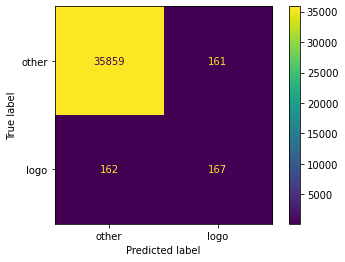

In [19]:
plot_confusion_matrix(clf_dt, X_test, y_test, display_labels=["other", "logo"])

In [114]:
# Let's see if we can improve the accuracy by pruning the tree (since it might be overfitting here)
path = clf_dt.cost_complexity_pruning_path(X_train, y_train) #determine values for alpha
ccp_alphas = path.ccp_alphas # extract different values for alpha
ccp_alphas = ccp_alphas[:-1] # exclude maximum value for alpha (as that's only the root of the tree)

clf_dts = [] # this holds all different decision trees

for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf_dt.fit(X_train, y_train)
    clf_dts.append(clf_dt)

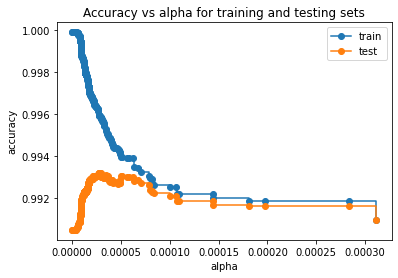

In [115]:
train_scores = [clf_dt.score(X_train, y_train) for clf_dt in clf_dts]
test_scores = [clf_dt.score(X_test, y_test) for clf_dt in clf_dts]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In [20]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, f1_score

In [27]:
# We use gridsearchCV to find the best parameters for the tree in relation to different scorers


param_grid = {
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26],
    'criterion': ['gini', 'entropy']
}

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score),
    'f1_score': make_scorer(f1_score)
}

def grid_search_wrapper(clf, refit_score='precision_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    skf = StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(clf, param_grid, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1)
    grid_search.fit(X_train.values, y_train.values)

    # make the predictions
    y_pred = grid_search.predict(X_test.values)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Decision Tree optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))

    print(grid_search.best_estimator_.get_params())
    return grid_search


In [159]:
grid_search_clf_prec = grid_search_wrapper(DecisionTreeClassifier(random_state=42), refit_score='precision_score')

/home/antip/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/antip/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/antip/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/antip/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWar

Best params for precision_score
{'criterion': 'entropy', 'max_depth': 6}

Confusion matrix of Decision Tree optimized for precision_score on the test data:
     pred_neg  pred_pos
neg     35946        74
pos       232        97


In [160]:
grid_search_clf_recall = grid_search_wrapper(DecisionTreeClassifier(random_state=42), refit_score='recall_score')

/home/antip/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/antip/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/antip/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/antip/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWar

Best params for recall_score
{'criterion': 'entropy', 'max_depth': 20}

Confusion matrix of Decision Tree optimized for recall_score on the test data:
     pred_neg  pred_pos
neg     35852       168
pos       154       175


In [161]:
grid_search_clf_f1 = grid_search_wrapper(DecisionTreeClassifier(random_state=42), refit_score='f1_score')

/home/antip/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/antip/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/antip/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/antip/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWar

Best params for f1_score
{'criterion': 'entropy', 'max_depth': 20}

Confusion matrix of Decision Tree optimized for f1_score on the test data:
     pred_neg  pred_pos
neg     35852       168
pos       154       175


In [162]:
grid_search_clf_acc = grid_search_wrapper(DecisionTreeClassifier(random_state=42), refit_score='accuracy_score')

/home/antip/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/antip/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/antip/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/antip/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWar

Best params for accuracy_score
{'criterion': 'entropy', 'max_depth': 8}

Confusion matrix of Decision Tree optimized for accuracy_score on the test data:
     pred_neg  pred_pos
neg     35917       103
pos       200       129


In [163]:
y_scores = grid_search_clf_acc.predict_proba(X_test)[:, 1]

p, r, thresholds = precision_recall_curve(y_test, y_scores)

/home/antip/.local/lib/python3.8/site-packages/sklearn/base.py:434: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


In [24]:
def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_scores]

def precision_recall_threshold(p, r, thresholds, t=0.5):
    """
    plots the precision recall curve and shows the current value for each
    by identifying the classifier's threshold (t).
    """
    
    # generate new class predictions based on the adjusted_classes
    # function above and view the resulting confusion matrix.
    y_pred_adj = adjusted_classes(y_scores, t)
    print(pd.DataFrame(confusion_matrix(y_test, y_pred_adj),
                       columns=['pred_neg', 'pred_pos'], 
                       index=['neg', 'pos']))
    
    # plot the curve
    plt.figure(figsize=(8,8))
    plt.title("Precision and Recall curve ^ = current threshold")
    plt.step(r, p, color='b', alpha=0.2,
             where='post')
    plt.fill_between(r, p, step='post', alpha=0.2,
                     color='b')
    plt.ylim([0.5, 1.01]);
    plt.xlim([0.5, 1.01]);
    plt.xlabel('Recall');
    plt.ylabel('Precision');
    
    # plot the current threshold on the line
    close_default_clf = np.argmin(np.abs(thresholds - t))
    plt.plot(r[close_default_clf], p[close_default_clf], '^', c='k',
            markersize=15)

     pred_neg  pred_pos
neg     35916       104
pos       200       129


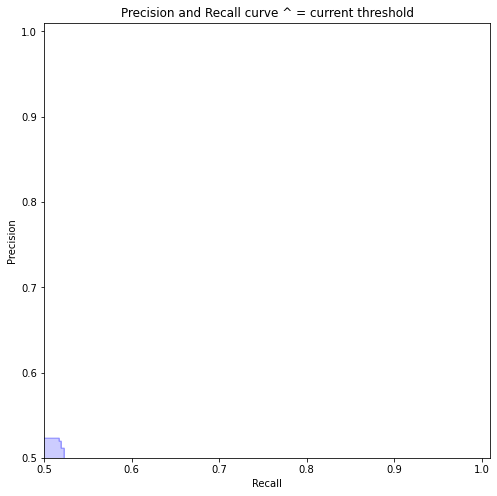

In [165]:
precision_recall_threshold(p, r, thresholds, 0.50)

In [25]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')

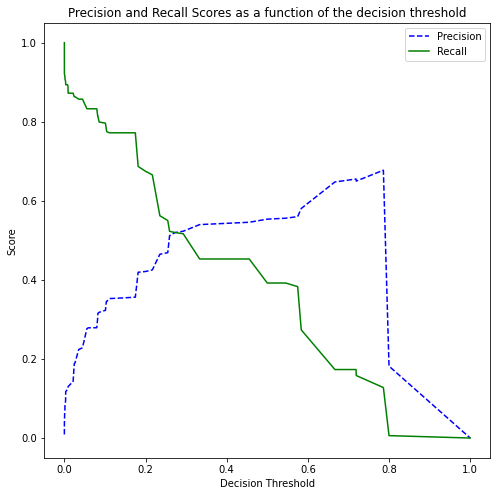

In [167]:
# use the same p, r, thresholds that were previously calculated
plot_precision_recall_vs_threshold(p, r, thresholds)

Now we do the same for the other classifiers, like random tree

variables to start with are X_train, X_test, y_train, y_test

In [21]:
from sklearn.ensemble import RandomForestClassifier

In [28]:
clf_rt = RandomForestClassifier(n_jobs=-1)

param_grid = {
    'min_samples_split': [3, 5], 
    'n_estimators' : [100, 300],
    'max_depth': [3, 5, 10, 15, 25],
    'max_features': [3, 5, 10]
}

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score),
    'f1_score': make_scorer(f1_score)
}

In [173]:
grid_search_clf_rt_acc = grid_search_wrapper(clf_rt, refit_score='accuracy_score')

/home/antip/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/antip/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/antip/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/antip/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWar

Best params for accuracy_score
{'max_depth': 15, 'max_features': 10, 'min_samples_split': 3, 'n_estimators': 100}

Confusion matrix of Decision Tree optimized for accuracy_score on the test data:
     pred_neg  pred_pos
neg     35981        39
pos       168       161


In [29]:
grid_search_clf_rt_recall = grid_search_wrapper(clf_rt, refit_score='recall_score')

/home/antip/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/antip/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/antip/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/antip/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWar

Best params for recall_score
{'max_depth': 15, 'max_features': 10, 'min_samples_split': 3, 'n_estimators': 100}

Confusion matrix of Decision Tree optimized for recall_score on the test data:
     pred_neg  pred_pos
neg     35977        43
pos       168       161


In [177]:
grid_search_clf_rt_f1 = grid_search_wrapper(clf_rt, refit_score='f1_score')

/home/antip/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/antip/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/antip/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/antip/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWar

Best params for f1_score
{'max_depth': 25, 'max_features': 10, 'min_samples_split': 3, 'n_estimators': 300}

Confusion matrix of Decision Tree optimized for f1_score on the test data:
     pred_neg  pred_pos
neg     35985        35
pos       171       158


In [178]:
y_scores = grid_search_clf_rt_recall.predict_proba(X_test)[:, 1]

p, r, thresholds = precision_recall_curve(y_test, y_scores)

/home/antip/.local/lib/python3.8/site-packages/sklearn/base.py:434: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


     pred_neg  pred_pos
neg     35979        41
pos       166       163


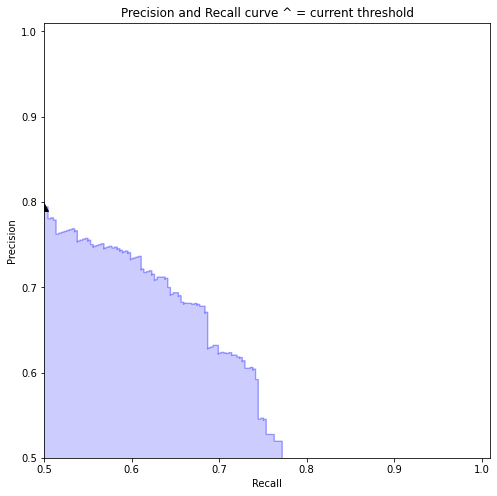

In [179]:
precision_recall_threshold(p, r, thresholds, 0.50)

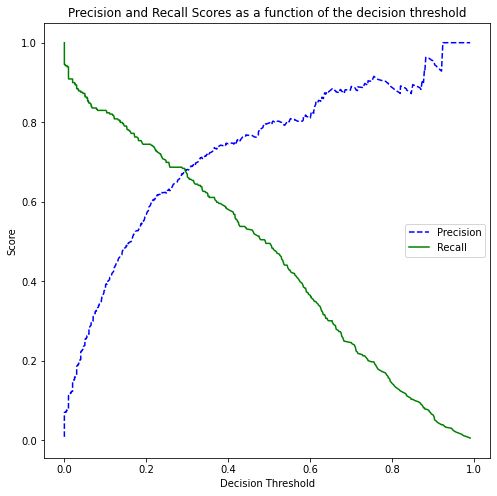

In [180]:
plot_precision_recall_vs_threshold(p, r, thresholds)

Now we do the same for the other classifiers, like logistic regression

variables to start with are X_train, X_test, y_train, y_test

In [43]:
from sklearn.linear_model import LogisticRegression

clf_lr = LogisticRegression()

param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001,0.01,0.1,1,10,100,1000],
    'solver': ['liblinear']
}

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score),
    'f1_score': make_scorer(f1_score)
}

In [44]:
grid_search_clf_lr_recall = grid_search_wrapper(clf_lr, refit_score='recall_score')

Best params for recall_score
{'C': 1000, 'penalty': 'l1', 'solver': 'liblinear'}

Confusion matrix of Decision Tree optimized for recall_score on the test data:
     pred_neg  pred_pos
neg     35980        40
pos       260        69


In [ ]:
# I think logistic regression is the worst of all

Interesting to see is the following. If we compute the probability of being a logo for each region in the X dataset, and we take the first k logos ordered by probability, in how many cases do we get an actual logo in these regions?

In [30]:
# First we get the original dataset again with the filepath in it
def_storage_phish = "db/new_region_data_phishing_labeled_filtered.db"
def_storage_benign = "db/new_region_data_benign_labeled_filtered.db"

# get phishing region data in dataframe
conn = sqlite3.connect(def_storage_phish)
df_phish = pd.read_sql_query("SELECT * from region_info", conn)
conn.close()

# get benign region data in dataframe
conn = sqlite3.connect(def_storage_benign)
df_benign = pd.read_sql_query("SELECT * from region_info", conn)
conn.close()

# combine the dataframes into a single dataframe
df_test = pd.concat([df_phish, df_benign], axis=0, ignore_index=True)



In [31]:
# drop the columns we do not need
df_test.drop(['region', 'child', 'parent', 'invert'], axis=1, inplace=True)

# fix the label column
df_test['label'] = df_test.apply(lambda row: 0 if row['label'] == '' else 1, axis=1)

# drop the NaN values
# TODO for real implementations, set proba to 0 for rows with NaN values
df_test = df_test.dropna()

In [32]:
df_test = df_test.reset_index(drop=True)
df_test['logo_prob'] = pd.Series(grid_search_clf_rt_recall.predict_proba(df_test.loc[:, "width":"occupied_bins"])[:, 1])
df_test

/home/antip/.local/lib/python3.8/site-packages/sklearn/base.py:434: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


,filepath,width,height,xcoord,ycoord,colourcount,dominant_colour_pct,mean,std,skew,kurtosis,entropy,otsu,energy,occupied_bins,label,logo_prob
0,58515e8b5ad0665e228cdde79f67db3f17fe1e2a,79,21,720,389,128,76.009644,238.003617,39.323820,-2.264105,3.592412,7.398034,194.0,608.730108,99,0,0.000000
1,58515e8b5ad0665e228cdde79f67db3f17fe1e2a,99,24,580,389,130,80.934343,241.354798,35.774758,-2.623722,5.442432,7.760278,196.0,520.857008,98,0,0.000000
2,58515e8b5ad0665e228cdde79f67db3f17fe1e2a,96,21,443,389,130,80.505952,240.431052,36.841725,-2.490892,4.732594,7.595130,196.0,579.461682,96,0,0.000000
3,58515e8b5ad0665e228cdde79f67db3f17fe1e2a,79,21,579,316,17,75.647981,216.761302,78.066452,-1.851478,1.864703,7.312316,143.0,2059.823388,17,0,0.000000
4,58515e8b5ad0665e228cdde79f67db3f17fe1e2a,299,62,460,278,256,75.072823,218.395188,76.708265,-1.973295,2.428986,9.727549,156.0,1054.561118,172,0,0.000924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310310,7540e74507f1e204574fa52ac6d9882086205c2d71acce...,21,26,400,365,524,0.549451,86.673993,28.699593,-0.350168,-0.892373,6.242708,83.0,140.086538,114,0,0.000000
310311,7540e74507f1e204574fa52ac6d9882086205c2d71acce...,14,12,386,328,164,1.190476,95.482143,15.554808,-0.118503,-0.314657,5.110437,94.0,57.013393,56,0,0.000000
310312,7540e74507f1e204574fa52ac6d9882086205c2d71acce...,27,23,748,194,34,11.433172,131.014493,1.541101,0.915506,0.496775,6.431262,131.0,0.155395,9,0,0.000000
310313,7540e74507f1e204574fa52ac6d9882086205c2d71acce...,50,30,609,49,146,4.533333,138.805333,31.168950,3.132367,8.365311,7.292277,179.0,324.535667,58,0,0.000000


In [33]:
df_test = df_test.drop_duplicates()

In [34]:
# df_test now contains the filepath, features, label and calculated probability of being a logo by random tree
grouped = df_test.groupby(['filepath'])
grouped

In [45]:
hit_rate = []
for k in range(1, 21):
    total = 0
    hit = 0
    for name, group in grouped:
        if (group['label'] == 1).any():
            total += 1
            group = group.nlargest(k, 'logo_prob', keep="first")
            if (group['label'] == 1).any():
                hit += 1
        else:
            continue
    hit_rate.append((k, hit/total))
print(f"Total: {total}")
hit_rate
        

Total: 1595


[(1, 0.9667711598746082),
 (2, 0.980564263322884),
 (3, 0.9855799373040752),
 (4, 0.9862068965517241),
 (5, 0.986833855799373),
 (6, 0.987460815047022),
 (7, 0.9880877742946709),
 (8, 0.9893416927899686),
 (9, 0.9893416927899686),
 (10, 0.9912225705329154),
 (11, 0.9937304075235109),
 (12, 0.9937304075235109),
 (13, 0.9937304075235109),
 (14, 0.9943573667711598),
 (15, 0.9943573667711598),
 (16, 0.9949843260188088),
 (17, 0.9949843260188088),
 (18, 0.9949843260188088),
 (19, 0.9956112852664577),
 (20, 0.9956112852664577)]

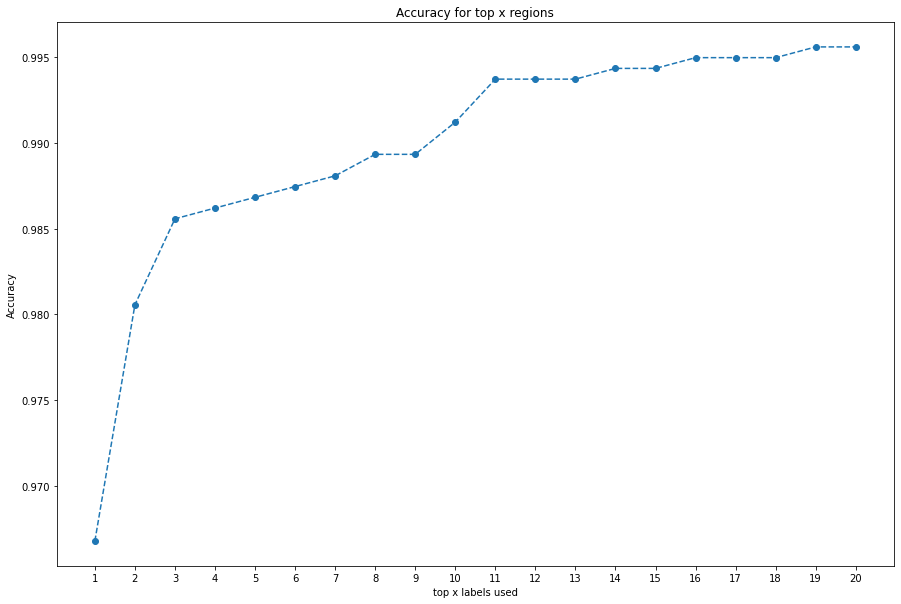

In [55]:
dt = np.dtype('int,float')
hit_rate_arr = np.array(hit_rate, dtype=dt)
hit_rate_arr.dtype.names = ['x', 'acc']
plt.title("Accuracy for top x regions")
plt.xlabel("top x labels used")
plt.xticks(hit_rate_arr['x'])
plt.ylabel("Accuracy")
plt.rcParams["figure.figsize"] = (10, 10)
plt.plot(hit_rate_arr['x'], hit_rate_arr['acc'], linestyle='--', marker='o')
plt.show()

In [39]:
# save this random tree to a file...
import joblib

joblib.dump(grid_search_clf_rt_recall, "gridsearch_clf_rt_recall.joblib")

['gridsearch_clf_rt_recall.joblib']

<AxesSubplot:>

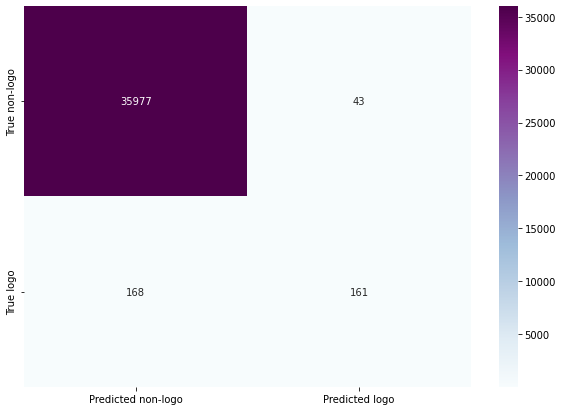

In [21]:
import seaborn as sn
arr = [[35977, 43], [168, 161]]
df_cm = pd.DataFrame(arr, index=['True non-logo', 'True logo'], columns=['Predicted non-logo', 'Predicted logo'])

plt.figure(figsize=(10, 7))
sn.heatmap(df_cm, annot=True, fmt='d', cmap='BuPu')
#pred_neg  pred_pos
#neg     35977        43
#pos       168       161